In [ ]:
---
title: "NYCTaxi"
author: "이민지(2023-202046394)"
format: dashboard
execute:
  enabled: true
  cache: false
  freeze: false
---

In [19]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import requests
import pickle

In [20]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"

In [22]:

df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

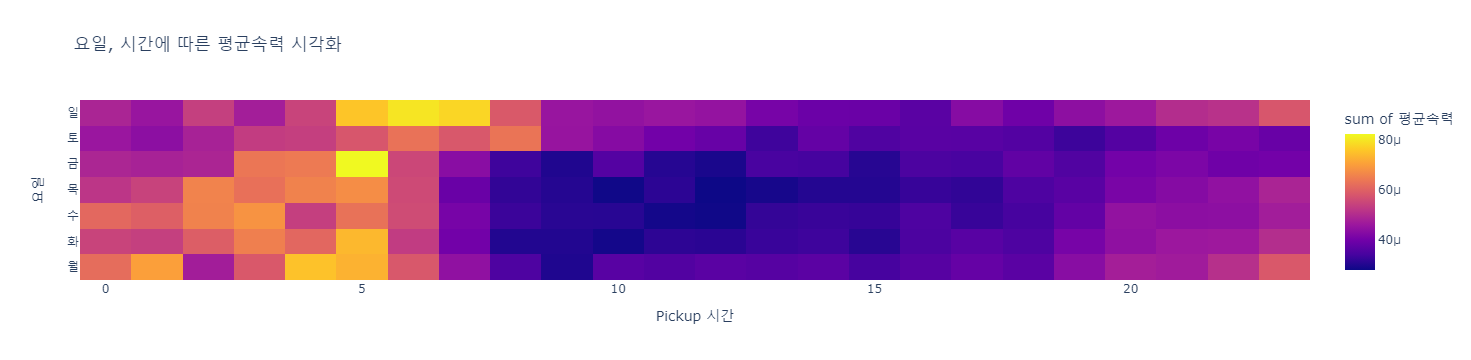

In [23]:

##| title: 요일,시간에 따른 평균속력 시각화   
 


dayofweek_mapping = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
df['dayofweek'] = df['dayofweek'].map(dayofweek_mapping)

# (요일, 시간)에 따른 평균속력 계산
average_speed_data = df.groupby(['dayofweek', 'pickup_hour'])['speed'].mean().reset_index()


fig1 = px.density_heatmap(
    data_frame=average_speed_data,
    x='pickup_hour',
    y='dayofweek',
    z='speed',
    nbinsx=24,
    nbinsy=7,
    height=300,
    labels={'pickup_hour': 'Pickup 시간', 'dayofweek': '요일', 'speed': '평균속력'},
    title='요일, 시간에 따른 평균속력 시각화',
    category_orders={'dayofweek': ['일', '토', '금', '목', '수', '화', '월']}
)


fig1.show()

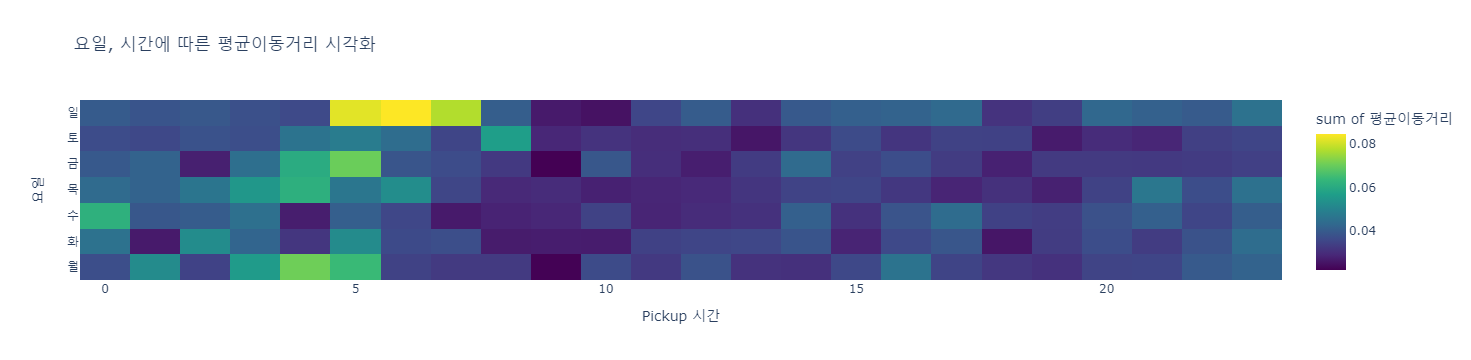

In [25]:
##| title: 요일,시간에 따른 평균이동거리 시각화    

# (요일, 시간)에 따른 평균 이동거리 계산
average_distance_data = df.groupby(['dayofweek', 'pickup_hour'])['dist'].mean().reset_index()

fig2 = px.density_heatmap(
    data_frame=average_distance_data,
    x='pickup_hour',
    y='dayofweek',
    z='dist',
    nbinsx=24,
    nbinsy=7,
    height=300,
    labels={'pickup_hour': 'Pickup 시간', 'dayofweek': '요일', 'dist': '평균이동거리'},
    title='요일, 시간에 따른 평균이동거리 시각화',
    category_orders={'dayofweek': ['일', '토', '금', '목', '수', '화', '월']},
    color_continuous_scale='Viridis',  # 원하는 색상 스케일로 변경
)


fig2.show()

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



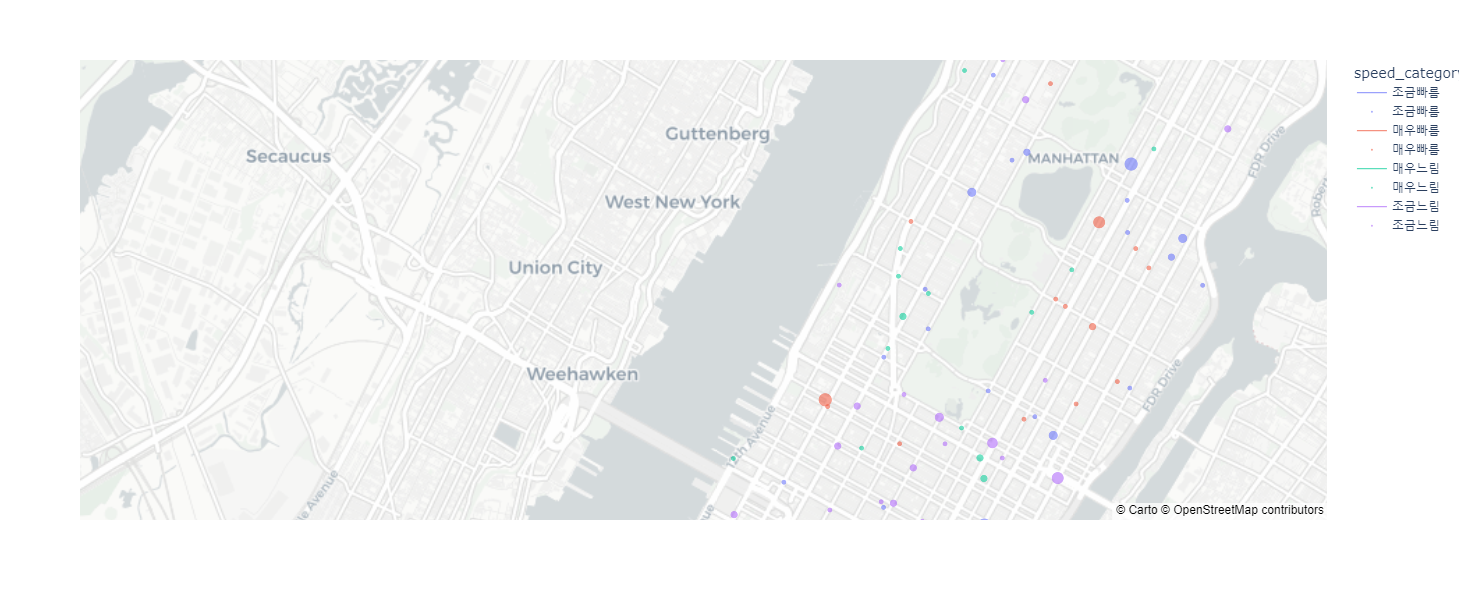

In [15]:
##| title: 속력별 경로 시각화
df_small['speed_category'] = pd.qcut(df_small['speed'], q=4, labels=['매우느림', '조금느림', '조금빠름', '매우빠름'])

zoom_level = 11


fig3 = px.line_mapbox(
    data_frame=df_small,
    lat='dropoff_latitude',
    lon='dropoff_longitude',
    color='speed_category',
    line_group='id',
    mapbox_style='carto-positron',
    zoom=zoom_level,
    width=750,
    height=600
)


scatter_data = px.scatter_mapbox(
    data_frame=df_small,
    lat='dropoff_latitude',
    lon='dropoff_longitude',
    size='passenger_count',
    size_max=10,
    color='speed_category',
    mapbox_style='carto-positron',
    zoom=zoom_level,
    width=750,
    height=600
).data

for sd in scatter_data:
    fig3.add_trace(sd)


fig3.update_traces(
    line={'width': 1},
    opacity=0.8
)


fig3.show(config={'scrollZoom': False})
